In [12]:
# Import libraries
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import tqdm

In [13]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)

cuda


In [14]:
main_folder = "/kaggle/input/iith-dl-contest-2024/train/train"

In [15]:
# Define a transform to read the data in as a tensor
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load the training data
train_data = datasets.ImageFolder(main_folder, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
print("Data loaded")
print("Number of training samples: ", len(train_data))
# print shape of training data
print("Shape of training data: ", train_data[0][0].shape)
print(train_data.classes)
print("Number of classes: ", len(train_data.classes))

Data loaded
Number of training samples:  65000
Shape of training data:  torch.Size([3, 128, 128])
['n01443537', 'n01774750', 'n01784675', 'n01882714', 'n01910747', 'n01944390', 'n01983481', 'n02056570', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02190166', 'n02206856', 'n02226429', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02364673', 'n02395406', 'n02410509', 'n02423022', 'n02480495', 'n02481823', 'n02486410', 'n02769748', 'n02793495', 'n02802426', 'n02808440', 'n02814860', 'n02843684', 'n02906734', 'n02948072', 'n02950826', 'n03424325', 'n03649909', 'n04133789', 'n04146614', 'n04275548', 'n04465501', 'n07695742', 'n07720875', 'n07734744', 'n07753592', 'n07768694', 'n07873807', 'n07920052', 'n12267677']
Number of classes:  50


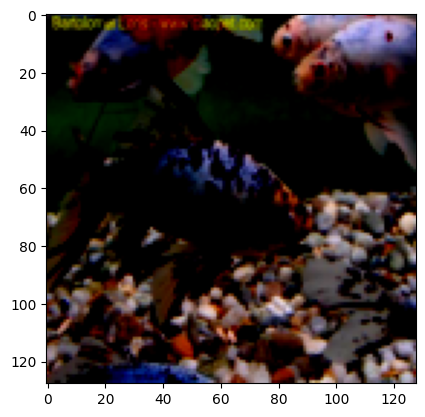

In [16]:
# print a sample image
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [22]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self,num_classes=50):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2,padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2,padding=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive average pooling to 1x1
        self.fc1 = nn.Linear(256 * 1 * 1, 128)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(128, num_classes)
        # self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, 256 * 1 * 1)  # Reshape to fit fully connected layer
        # x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

# create a complete CNN
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
)


In [24]:
# once print the device
print(device)
# specify loss function
criterion = nn.CrossEntropyLoss()

# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# number of epochs to train the model
n_epochs = 15


# above using tqdm
model.train()
for epoch in range(n_epochs):
    train_loss=0.0
    correct=0
    total=0
    for data, target in tqdm.tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    train_loss = train_loss/len(train_loader.dataset)
    acc = 100 * correct / total
    print('Epoch: {} \tTraining Loss: {:.6f} \tAccuracy: {:.2f}'.format(epoch+1, train_loss, acc))

cuda


  4%|▍         | 42/1016 [00:15<06:03,  2.68it/s]


KeyboardInterrupt: 

In [24]:
# predict a sample image
model.eval()
data, target = train_data[0]
data = data.unsqueeze(0).to(device)
output = model(data)
_, pred = torch.max(output, 1)
print("Predicted label: ", train_data.classes[pred.item()])
print("True label: ", train_data.classes[target])

Predicted label:  n01882714
True label:  n01443537


In [25]:
# accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 41 %


In [ ]:
test_dir="/kaggle/input/iith-dl-contest-2024/test"
test_data = datasets.ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

model.eval()
preds = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        preds += pred.cpu().numpy().tolist()
        
        
# print(preds)

In [31]:
# get class names
class_names = train_data.classes
# create a submission file
results = [(f"{index}.JPEG", class_names[pred]) for index, pred in enumerate(preds)]
import pandas as pd
df = pd.DataFrame(results, columns=["ID", "Category"])
df.to_csv("/kaggle/working/submission.csv", index=False)


In [32]:
torch.save(model.state_dict(),"/kaggle/working/11apr.pth")
